## Uniqueness Score Calculation for Modalities and Indications

Uniqueness quantifies how distinct a company's indications and modalities are at a given point in time. It reflects the rarity of a company's focus areas, with the premise that companies operating in less common spaces may have a higher likelihood of drug approval.

## Load Raw Data

In [1]:
import pandas as pd
import os

# Define base data directory
DATA_DIR = os.path.abspath("../../data/raw")

# Load datasets
returns = pd.read_csv(os.path.join(DATA_DIR, "closing_prices.csv"))
print("Returns shape: ", returns.shape)
assert returns.shape == (334817, 3)

mod_ind = pd.read_csv(os.path.join(DATA_DIR, "mod_ind.csv"))
print("mod_ind shape: ", mod_ind.shape)
assert mod_ind.shape == (1720, 30)

# NOTE: 
# - Some companies were not captured in the  BIOTECH_PROJECT.READ_ONLY.DESCRIPTIONS dataset that exist in the BIOTECH_PROJECT.INTERNS.BIOTECH_FACTORS/sage dataset
#   for these companies they are dropped before the regression (we could generate these descriptions but maybe we should wait until we do a more comprehensive scraping)

Returns shape:  (334817, 3)
mod_ind shape:  (1720, 30)


## Merge and Clean Raw Data

In [2]:
# Merge datasets on COMPANY_ID
merged_data = pd.merge(returns, mod_ind, on='COMPANY_ID', how='left')

# Convert PRICING_DATE to datetime, rename column
merged_data['MONTH_END'] = pd.to_datetime(merged_data['PRICING_DATE']) + pd.offsets.MonthEnd(0)

# Create month and year columns
merged_data['YEAR'] = merged_data['MONTH_END'].dt.year
merged_data['MONTH'] = merged_data['MONTH_END'].dt.month

# Drop duplicate rows based on COMPANY_ID, YEAR, and MONTH, keeping the first occurrence
merged_data = merged_data.drop_duplicates(subset=['COMPANY_ID', 'YEAR', 'MONTH'], keep='first')

# Drop helper and unneeded columns
merged_data = merged_data.drop(columns=['YEAR', 'MONTH', 'PRICING_DATE'], errors='ignore')

# NOTE: 
# - The PRICE_CLOSE_USED is not acutally used, the "returns" dataset is just used to retrieve when companies entered and exited the market

In [3]:
print(merged_data.head(10).to_markdown())

|    |   COMPANY_ID |   PRICE_CLOSE_USD |   ONCOLOGY |   NEUROLOGY/PSYCHIATRY |   CARDIOVASCULAR/METABOLIC |   IMMUNOLOGY/AUTOIMMUNE |   INFECTIOUS DISEASES |   HEMATOLOGY |   GASTROINTESTINAL/HEPATOLOGY |   DERMATOLOGY |   OPHTHALMOLOGY |   RESPIRATORY |   UROLOGY/RENAL |   PAIN MANAGEMENT/ANESTHETICS |   PROTEIN/MONOCLONAL ANTIBODIES |   PROTEIN/OTHERS |   PEPTIDES/AMINO ACIDS WITH MORE THAN 40 RESIDUES |   PEPTIDES/AMINO ACIDS WITH FEWER THAN 40 RESIDUES (SHORT PEPTIDES) |   PEPTIDES/CYCLIC |   PEPTIDES/PEGYLATED |   PEPTIDES/OTHERS |   SMALL MOLECULES AND NATURAL PRODUCTS |   NUCLEIC ACIDS/MRNA |   NUCLEIC ACIDS/SIRNA |   NUCLEIC ACIDS/ASO (ANTISENSE OLIGONUCLEOTIDES) |   NUCLEIC ACIDS/OTHERS |   NUCLEIC ACIDS/OLIGONUCLEOTIDES (OLIGOS) |   CELL AND GENE THERAPY |   VACCINES |   IMAGING AGENTS |   COMBINATION THERAPIES | MONTH_END           |
|---:|-------------:|------------------:|-----------:|-----------------------:|---------------------------:|------------------------:|--------

# Load Features 

In [4]:
# Load the modalities and indications from the resources folder.
RESOURCES_DIR = os.path.abspath("../../resources")
with open(os.path.join(RESOURCES_DIR, "modaliities.txt"), "r") as f:
    modalities = [line.strip().upper() for line in f]
with open(os.path.join(RESOURCES_DIR, "indications.txt"), "r") as f:
    indications = [line.strip().upper() for line in f]


# Define the binary feature columns.
features = modalities + indications 
print(f'Using {len(features)} binary features: {features}')

Using 29 binary features: ['PROTEIN/MONOCLONAL ANTIBODIES', 'PROTEIN/OTHERS', 'PEPTIDES/AMINO ACIDS WITH MORE THAN 40 RESIDUES', 'PEPTIDES/AMINO ACIDS WITH FEWER THAN 40 RESIDUES (SHORT PEPTIDES)', 'PEPTIDES/CYCLIC', 'PEPTIDES/PEGYLATED', 'PEPTIDES/OTHERS', 'SMALL MOLECULES AND NATURAL PRODUCTS', 'NUCLEIC ACIDS/MRNA', 'NUCLEIC ACIDS/SIRNA', 'NUCLEIC ACIDS/ASO (ANTISENSE OLIGONUCLEOTIDES)', 'NUCLEIC ACIDS/OTHERS', 'NUCLEIC ACIDS/OLIGONUCLEOTIDES (OLIGOS)', 'CELL AND GENE THERAPY', 'VACCINES', 'IMAGING AGENTS', 'COMBINATION THERAPIES', 'ONCOLOGY', 'NEUROLOGY/PSYCHIATRY', 'CARDIOVASCULAR/METABOLIC', 'IMMUNOLOGY/AUTOIMMUNE', 'INFECTIOUS DISEASES', 'HEMATOLOGY', 'GASTROINTESTINAL/HEPATOLOGY', 'DERMATOLOGY', 'OPHTHALMOLOGY', 'RESPIRATORY', 'UROLOGY/RENAL', 'PAIN MANAGEMENT/ANESTHETICS']


# Create 'uniqueness' Variable

In [5]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Function to compute uniqueness scores for a given group of companies
def compute_uniqueness_for_group(df: pd.DataFrame, features: list[str], k=20) -> np.array:
    """
    Computes the uniqueness score for each company in the given group based on 
    feature similarity using the Hamming distance.

    Parameters:
    - df: DataFrame containing company data.
    - features: List of feature column names to compare.
    - k: Number of nearest neighbors to consider (default is 20).

    Returns:
    - A NumPy array containing uniqueness scores for each company.
    """
    # If there is only one company in the group, assign it a uniqueness score of 1 (fully unique).
    if df.shape[0] == 1:
        return np.array([1.0])
    
    # Extract feature values as a NumPy array.
    X = df[features].values
    
    # Ensure k does not exceed the number of available companies - 1.
    k_nn = min(k, df.shape[0] - 1)
    
    # Initialize Nearest Neighbors model using Hamming distance (suitable for binary vectors).
    nbrs = NearestNeighbors(n_neighbors=k_nn + 1, metric='hamming', algorithm='auto').fit(X)
    
    # Compute distances to the k nearest neighbors.
    distances, _ = nbrs.kneighbors(X)
    
    
    # Exclude self-distance (always 0 in the first column) and compute the mean distance to neighbors.
    uniqueness = distances[:, 1:].mean(axis=1)
    
    return uniqueness

# Function to compute and add uniqueness scores for each group (grouped by month-year).
def add_uniqueness_scores(group):
    """
    Computes uniqueness scores for each company within a given time-based group 
    and adds the scores as a new column.

    Parameters:
    - group: DataFrame group containing company data for a specific time period.

    Returns:
    - The updated DataFrame group with an added 'uniqueness' column.
    """
    group = group.copy()  # Ensure original data is not modified
    group['uniqueness'] = compute_uniqueness_for_group(group, features, k=100)
    return group

# Group data by the 'MONTH_END' period (month-year) and compute uniqueness scores for each group.
merged_data = merged_data.groupby(merged_data['MONTH_END'].dt.to_period('M'), group_keys=False)\
                         .apply(add_uniqueness_scores)\
                         .reset_index(drop=True)

# Sort the final DataFrame by company ID and month-end date in descending order for clarity.
merged_data = merged_data.sort_values(by=['COMPANY_ID', 'MONTH_END'], ascending=[True, False])

# Drop unnecessary columns (PRICE_CLOSE_USD and feature columns) to retain only relevant information.
merged_data = merged_data.drop(columns=['PRICE_CLOSE_USD'] + features)

# Plot Aggregate Uniqueness Over Time

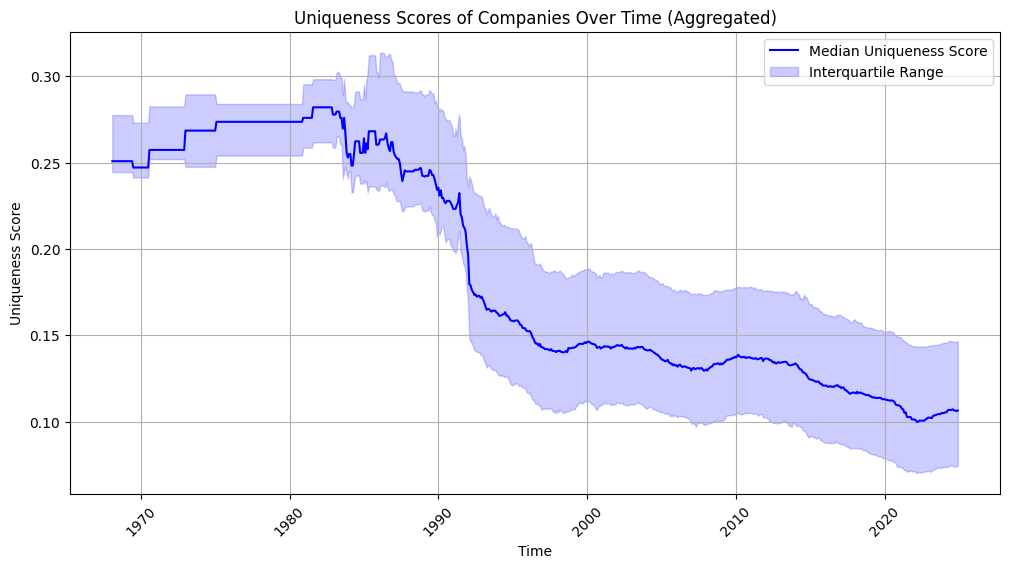

In [6]:
import matplotlib.pyplot as plt

# Aggregate uniqueness scores by computing the median and interquartile range
summary_data = merged_data.groupby('MONTH_END')['uniqueness'].agg(['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)]).reset_index()
summary_data.columns = ['MONTH_END', 'median', 'q25', 'q75']

# Plot median uniqueness scores with interquartile range shading
plt.figure(figsize=(12, 6))
plt.plot(summary_data['MONTH_END'], summary_data['median'], label='Median Uniqueness Score', color='blue')
plt.fill_between(summary_data['MONTH_END'], summary_data['q25'], summary_data['q75'], color='blue', alpha=0.2, label='Interquartile Range')

plt.xlabel('Time')
plt.ylabel('Uniqueness Score')
plt.title('Uniqueness Scores of Companies Over Time (Aggregated)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Plot Uniqueness Over Time for 20 Random Companies

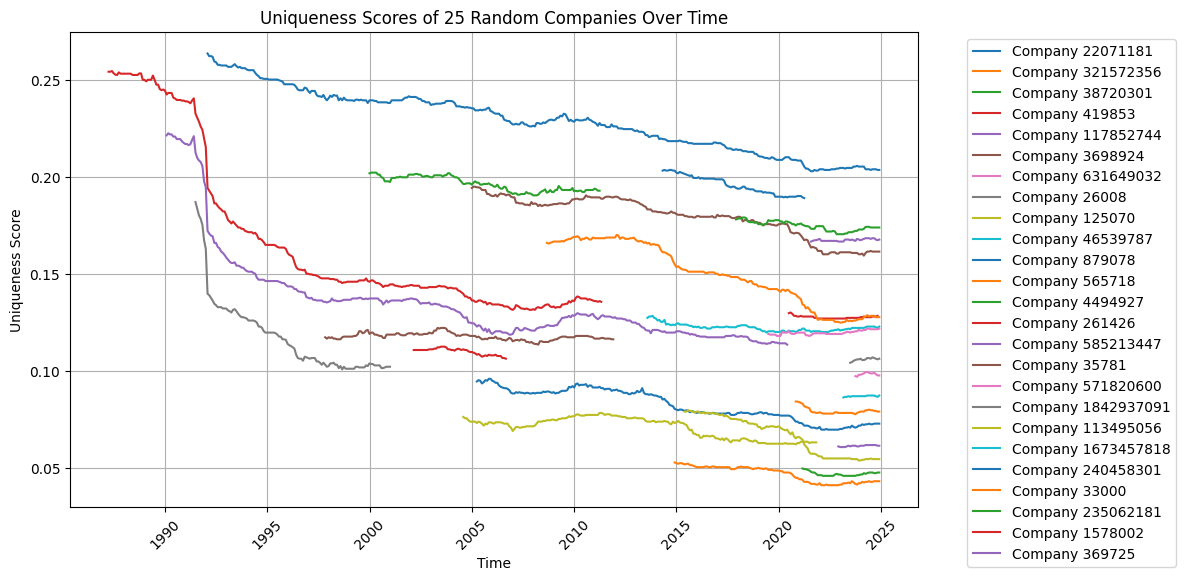

In [7]:
# Sample n random companies
n = 25
random_companies = np.random.choice(merged_data['COMPANY_ID'].unique(), size=n, replace=False)

# Filter the data for the selected companies
filtered_data = merged_data[merged_data['COMPANY_ID'].isin(random_companies)]

# Plot uniqueness scores for the selected companies over time
plt.figure(figsize=(12, 6))

for company in random_companies:
    company_data = filtered_data[filtered_data['COMPANY_ID'] == company]
    plt.plot(company_data['MONTH_END'], company_data['uniqueness'], label=f'Company {company}')

plt.xlabel('Time')
plt.ylabel('Uniqueness Score')
plt.title(f'Uniqueness Scores of {n} Random Companies Over Time')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

## Output Processed Data

In [8]:
# Save the final DataFrame to a CSV file.
OUTPUT_DIR = os.path.abspath("../../data/processed")
merged_data.to_csv(os.path.join(OUTPUT_DIR, "uniqueness.csv"), index=False)

In [9]:
# 2/24 Meeting Notes
    # create a table for uniqueness score for a company across time 
    # company id, month end, uniqueness score decile for that month, forward one month return
    # how much doese uniqueness score chagne by company 
    # calcualte returns by decile for uniquness score (avg returns)
    # try to understand why it is working so well not driven by outlizer (z-score of 50 etc.)